# Inferring graphs from survey data

In this notebook we discuss a simple method for representing survey data using graphs. This is where the [_surveygraph_](https://github.com/surveygraph) package comes in.

We assume users have a basic knowledge of R and graphs. In particular, we will be working with the _igraph_ package in order to visualise and analyse the graph data produced by _surveygraph_. An introduction to R and _igraph_ can be found on the _surveygraph_ [Github page](https://github.com/surveygraph/surveygraph-tutorials).

## Similarity measure

The main idea in this method is to compare the responses of pairs of individuals, and come up with a measure of their similarity. This is a similar notion to a distance metric. We define similarity as a number between 0 and 1 measuring the distance between individual responses.

### Respondent similarity



As a very simple example, let's consider the following survey where individuals respond to a single statement on a five-point Likert scale. Suppose the statement is _I enjoy programming in the R language_, with 1 being strongly disagree, and 5 being strongly agree. We refer to this question as _item one_ in this survey.

|id|item one|
|:-|:-|
|_Sam_|4|
|_Ana_|5|
|_Caoimhe_|4|
|_Paul_|2|
|_Megan_|1|
|_David_|3|

A simple measure of similarity uses the normalised difference between the users' responses. On an L-point Likert scale, these differences take the values 0, 1, 2, ..., L - 1. To force these differences within the range 0 to 1, we divide, or normalise the difference by L - 1. If we were to leave it at that, a normalised difference of 0 mean individuals respond identically, and a difference of 1 means they are as far apart as possible. Since we want a positive measure of similarity, we subtract the normalised difference from 1.

Let's apply this to the above survey. Consider Sam and Ana, whose responses are 4 and 5, respectively. The difference between their responses is 1. The normalised difference is 0.25, meaning their similarity is 0.75.

The idea simply is to treat this matrix as a complete weighted graph. The weighted neighbour list corresponding to the above table is

<div class='sidenote-cell'>
We can formalise this measure as follows. For a given item on an $L$-point Likert scale, if $r_u$ and $r_v$ are the responses of individuals $u$ and $v$, respectively, the similarity $s$ between $u$ and $v$ is given by 
\begin{equation}
    s = 1 - \dfrac{|r_u - r_v|}{L - 1}.
\end{equation}
</div>

By comparing each pair of respondents in the above example, we produce the symmetric table of similarities below. We have referred to this as the agent, or respondent projection of the survey.

||_Sam_|_Ana_|_Caoimhe_|_Paul_|_Megan_|_David_|
|:-|:-|:-|:-|:-|:-|:-|
|_Sam_|-| 0.75| 1.0| 0.5| 0.25| 0.75|
|_Ana_| 0.75|-| 0.75| 0.25| 0.0| 0.5|
|_Caoimhe_| 1.0| 0.75|-| 0.5| 0.25| 0.75|
|_Paul_| 0.5| 0.25| 0.5|-| 0.75| 0.5|
|_Megan_|0.25|0.0|0.25|0.75|-|0.5|
|_David_|0.75|0.5|0.75|0.75|0.5|-|

In [1]:
el1 <- data.frame(
    u = c('Sam','Sam','Sam','Sam','Sam','Ana','Ana','Ana','Ana','Caoimhe','Caoimhe','Caoimhe','Paul','Paul','Megan'),
    v = c('Ana','Caoimhe','Paul','Megan','David','Caoimhe','Paul','Megan','David','Paul','Megan','David','Megan','David','David'),
    weight = c(0.75,1,0.5,0.25,0.75,0.75,0.25,0,0.5,0.5,0.25,0.75,0.75,0.5,0.75)
)

Let's load the _igraph_ package in order to visualise this graph,

In [2]:
library('igraph')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




specifically by reading in our data frame as follows.

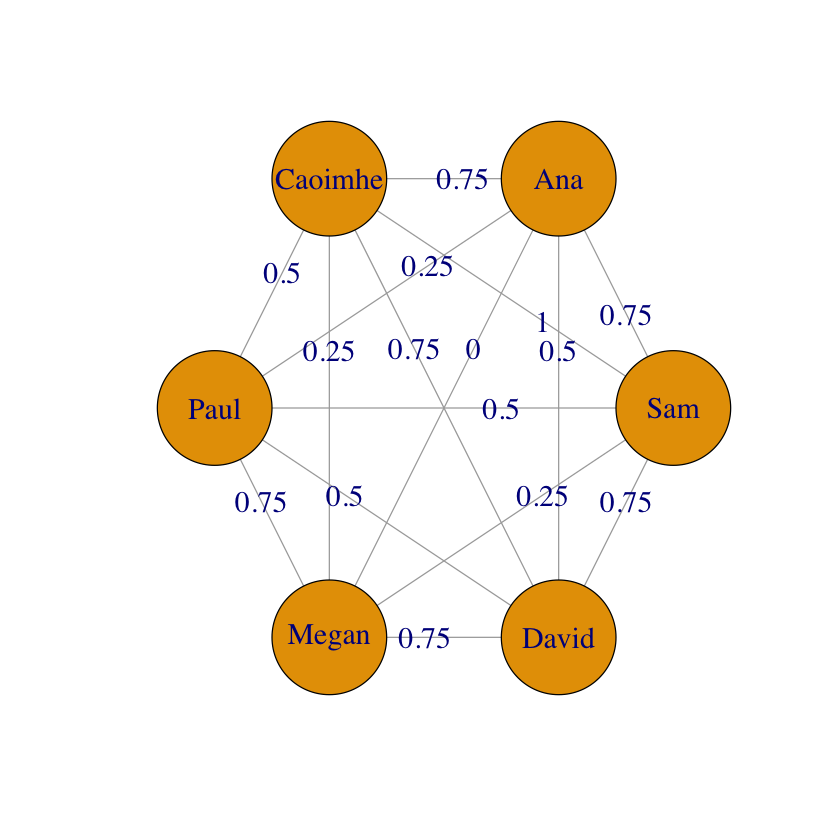

In [3]:
g <- graph_from_data_frame(el1, directed=FALSE)

plot(
    g, 
    layout=layout.circle,
    vertex.size = 50,
    vertex.label.cex = 1.5,
    edge.label = E(g)$weight,
    edge.label.cex = 1.5,
)

Trivially, we can express this as complete weighted graph, in which nodes are survey respondents, and edge weights are the similarity scores of adjacent nodes. Rewriting the above table in neighbour list format gives

|||||||
|:-|:-|:-|:-|:-|:-|
|_Sam_|_Ana_ 0.75|_Caoimhe_ 1.0|_Paul_ 0.5|_Megan_ 0.25|_David_ 0.75|
|_Ana_|_Sam_ 0.75|_Caoimhe_ 0.75|_Paul_ 0.25|_Megan_ 0.0|_David_ 0.5|
|_Caoimhe_|_Sam_ 1.0|_Ana_ 0.75|_Paul_ 0.5|_Megan_ 0.25|_David_ 0.75|
|_Paul_|_Sam_ 0.5|_Ana_ 0.25|_Caoimhe_ 0.5|_Megan_ 0.75|_David_ 0.5|
|_Megan_|_Sam_ 0.5|_Ana_ 0.25|_Caoimhe_ 0.5|_Paul_ 0.75|_David_ 0.5|
|_David_|_Sam_ 0.5|_Ana_ 0.25|_Caoimhe_ 0.5|_Paul_ 0.75|_Megan_ 0.5|

When we take into account multiple survey items, we simply compute the average of the similarity scores for each item. The resulting average similarity is therefore between 0 and 1 too.

### Item similarity

Almost identical to the above, we can compare the responses of a single individual across multiple items to compute a similarity score between items. Here, it is important to normalise _before_ computing the differences between responses, since a response of 3 on a 5-point Likert scale is different to 3 on a 5-point Likert scale.

|u|item one|item two|item three|
|:-|:-|:-|:-|
|_Ana_|2|5|2|

For example, assume items 1 and 2 correspond to a 5-point Likert scale, and item 3 a 3-point Likert scale. Normalising each response according to the formulat $(r_i - 1) / (L_i - 1)$ we get

|u|item one|item two|item three|
|:-|:-|:-|:-|
|_Ana_|0.25|1|0.5|

We infer the range of the Likert scale by examining the entire survey, assuming that at least one individual for each item has provided the maximum and minimum responses.

Now we can compute the similarity of each pair of items as before, producing the table

||item one|item two|item three|
|:-|:-|:-|:-|
|item one|-|0.75|0.25|
|item two|0.75|-|0.5|
|item three|0.25|0.5|-|

For completeness, the same data in a complete weighted neighbour list format is 

||||
|:-|:-|:-|
|_item one_|_item two_ 0.75|_item three_ 0.25|
|_item two_|_item one_ 0.75|_item three_ 0.5|
|_item three_|_item one_ 0.25|_item two_ 0.5|

Now let's write this as an R dataframe,


In [4]:
el2 <- data.frame(
    u = c('item1', 'item1', 'item2'),
    v = c('item2', 'item3', 'item3'),
    weight = c(0.75, 0.25, 0.5)
)

and visualise in R as before.

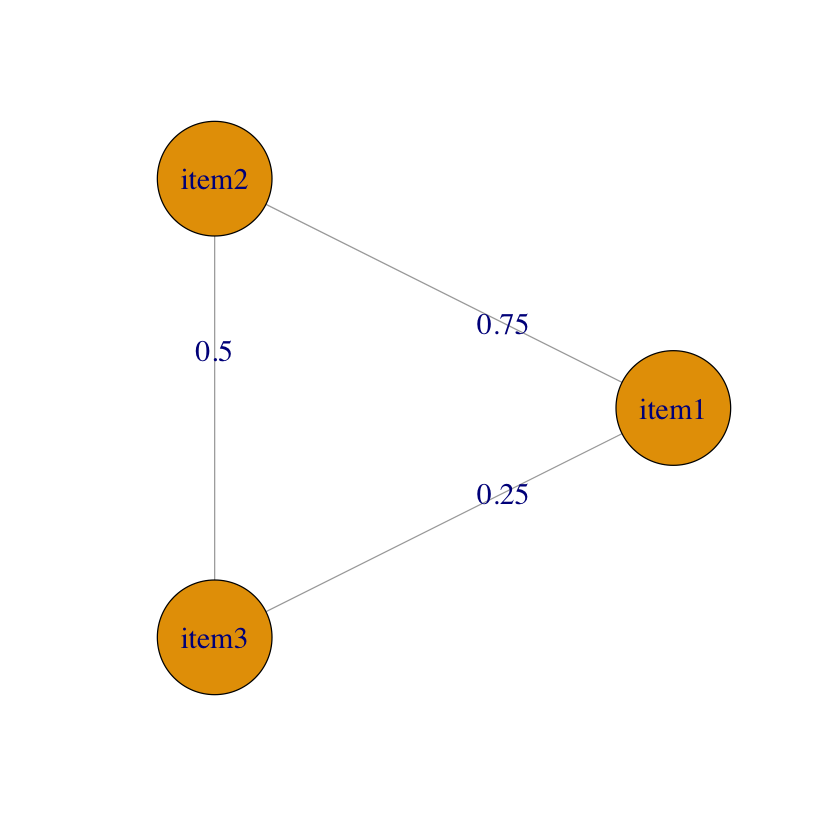

In [5]:
g <- graph_from_data_frame(el2, directed=FALSE)

plot(
    g, 
    layout=layout.circle,
    vertex.size = 50,
    vertex.label.cex = 1.5,
    edge.label = E(g)$weight,
    edge.label.cex = 1.5,
)

This represents the tables above as expected.

<div class='sidenote-cell'>
We can formalise this measure as follows. For a given individual responding to an $L_i$ and $L_j$ point Likert scales, if $r_i$ and $r_j$ are the responses to items $i$ and $j$, respectively, the similarity $s$ between items $i$ and $j$ is given by 
\begin{equation}
    s = 1 - \left|\dfrac{r_i - 1}{L_i - 1} - \dfrac{r_j - 1}{L_j - 1}\right|.
\end{equation}
This may appear different to the similarity measure for respondents, however substituting $i$ and $j$ for $u$ and $v$ gives
\begin{equation}
s = 1 - \left|\dfrac{r_u - 1}{L_u - 1} - \dfrac{r_v - 1}{L_v - 1}\right| = 1 - \dfrac{|r_u - r_v|}{L - 1},
\end{equation}
which is identical to the expression above. We've used the fact that $L = L_u = L_v$ following our notation in the previous section, as we're comparing the responses of individuals for a single item, meaning the Likert scale is identical across responses.
<br><br>
In practice, when we read in a survey with the <i>surveygraph</it> package, one of the pre-processing steps is to normalise all responses in this way prior to comparing responses across individuals or items.
</div>

### Thresholding similarity values

The idea is to use this use a network to represent relations between individuals with similar attitudes. This makes it evident for example if respondents are polarised in some way. In the following we see that Sam, Ana, Caoimhe and David form an almost complete cluster, or clique. David serves as a bridge between this cluster, and Megan and Paul. We can see how this corresponds to our original data.

We use the base R function `subset()` to keep only similarity weights greater than 0.6.

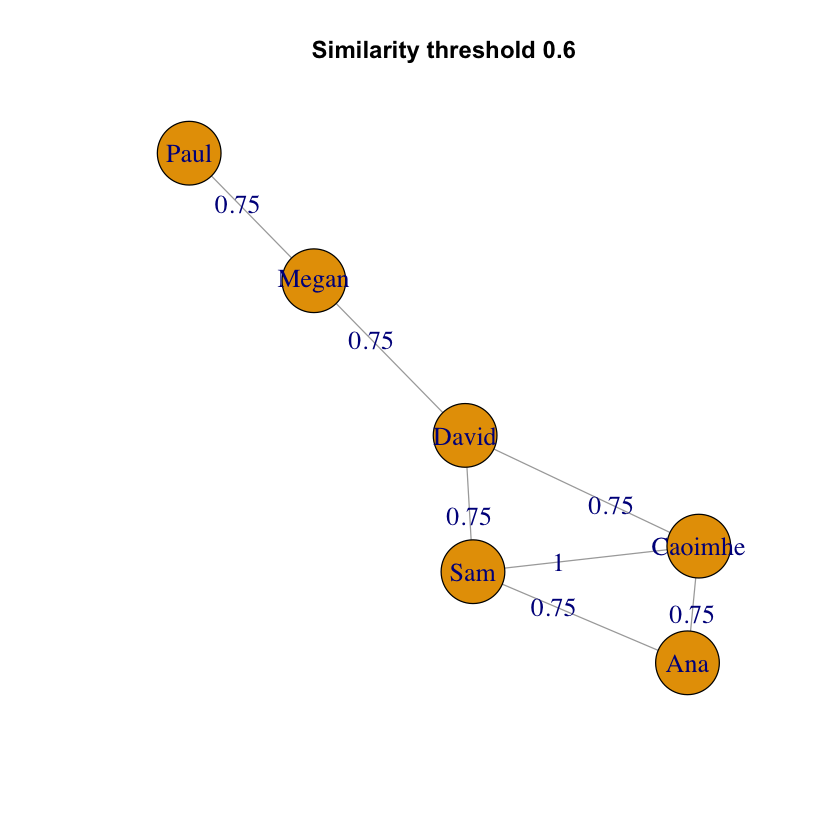

In [6]:
# threshold similarities
elthresh <- subset(el1, weight >= 0.6)

# load the edge list into igraph 
gthresh <- graph_from_data_frame(elthresh, directed=FALSE)

plot(
    gthresh, 
    layout=layout.fruchterman.reingold,
    vertex.size = 25,
    vertex.label.cex = 1.3,
    edge.label = E(gthresh)$weight,
    edge.label.cex = 1.3,
    main="Similarity threshold 0.6",
)

### Error and uncertainty

Let us make an aside on error and uncertainty, which initial work on this idea has not considered.

A simple technique is currently in beta in the _surveygraph_ package. It involves keeping this simple model of similarity, and adding noise to the survey data. Over many real realisations of this process, we can associated frequencies with each edge, namely the fraction of realisations in which the edge was present.

This relates to Monte Carlo simulation, bootstrap resampling, error propagation, sensitivity analysis.

We emphasise that this is a subject of future work, and we have not yet published work using this technique. 

## Example with model survey data

The example above was coded entirely by hand. The _surveygraph_ package performs the exact same computation, but using a C++ extension. In a large dataset, comparison of all pairs of indivuals grows with the square of the number of individuals, which can be costly in base R.

To demonstrate this, let's load _surveygraph_,

In [7]:
library('surveygraph')

and use the built-in method `make_synthetic_data()` to produce a simple mode of a survey.

In [8]:
S <- make_synthetic_data(
    nrow=500, 
    ncol=10, 
    polarisation=0.22, 
    correlation=0.9,
    minority=0.2,
)

Using the summary function `str()`, we see that we've created a survey consisting of 500 observations, or individuals,  responding to 10 items. We also see that there is a group label which is either 0 or 1.  `polarisation` is a measure of the distance between the two groups, `correlation` relates to the group id of respondents and response type. That is, the correlation between the group type and the dimension of the polarisation.

In [9]:
head(S,10)

group item_1 item_2 item_3 item_4 item_5 item_6 item_7 item_8 item_9 item_10
1  0      7     8       5      7     1      6      5      2      2      3      
2  0      6     5       7      9     3      6      4      4      5      7      
3  0      8     7       7      6     4      6      4      1      7      7      
4  0      3     5       8      9     1      3      3      4      4      3      
5  0     10     5       5     10     4      3      9      3      5      3      
6  1      7     4       5      9     5      4      6      5      6      6      
7  0      7     9       6      5     4      2      5      8      3      4      
8  0      4     9      10      5     5      4      6      6      2      5      
9  0      7     8       7     10     3      1      4      2      4      5      
10 0      9     6       7      7     2      3      6      3      2      4

While 500 is relatively small compared to some of the larger datasets out there, it is too large to compute the similarities by hand, as we did with our previous example. The number of pairwise similarities we have to compute is 124,750. Not only is that prohibitively time consuming, it would be difficult to actually plot the graph since it would be too dense, and almost impossible to interpret.

This is where _surveygraph_ comes in. What we'll do is perform these 124,750 comparisons, and instead of the complete graph, we'll automatically apply a threshold that sparsifies the graph.

In [10]:
e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=1.0
)

The terms that appear in the arguments of this function are as follows

* `S` a survey in dataframe format
* `layer` flag specifying we want the respondent or agent network, in this case `agent`
* `threshold_method` out criteria for choosing a similarity threshold, in this case `target_lcc`, which means we set the threshold that gives us a specified largest connected component size
* `method_value` variable associated with the threshold method, which here is the lcc size

Let's convert the edge list into in _igraph_ format

In [11]:
g <- graph_from_data_frame(e, directed=FALSE)

and visualise using the Fruchterman-Reingold layout.

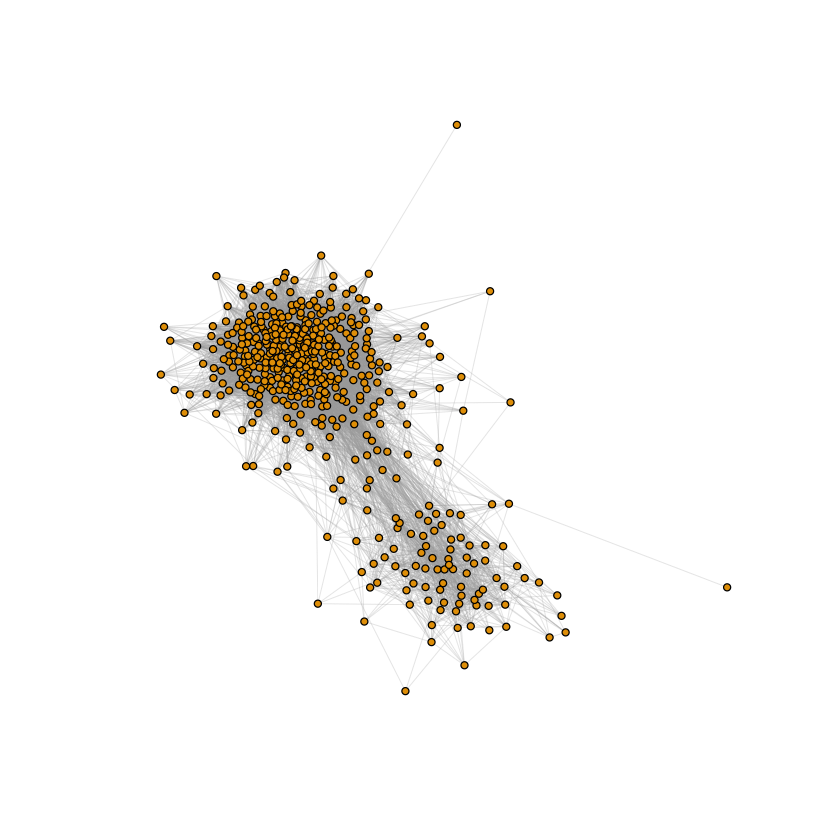

In [12]:
plot(
    g, 
    vertex.size=2.5, 
    vertex.label=NA, 
    edge.width=0.2, 
    layout=layout.fruchterman.reingold
)

### Considering group information

Let's make use of the group identity data in our graph, which is the `S$group` column of our model survey. To incorporate node data, functions in _igraph_ take an optional `vertices` argument in the form of a data frame that describes node features. The following creates a dataframe called `nodedata` containing an `id` column for node index, and a `group` column for a node's group index, which is either 0 or 1 in our dataset.

After recreating the graph in _igraph_ using this information, group information is accessible with the syntax `V(g)$group`.

In [13]:
nodedata <- data.frame(id=c(1:length(S$group)), group=S$group)

Setting the `vertices` argument to `nodedata` when we recompute the graph creates a `group` attribute for each node in the graph. If we wish to add more node metadata, we would simply add columns to the `nodedata` dataframe. For example, each node might have an `age` variable, which we'd access with `V(g)$age`.

In [14]:
g <- graph_from_data_frame(e, vertices=nodedata, directed=FALSE)

We then use the `ifelse()` function in R to assign the built-in variable `color` according to the group value in our synthetic survey data. This function takes three arguments, namely a boolean, and a return value each for when the function is true or false. For example

In [15]:
var <- 1

# ifelse(var == 0, "blue", "red")

# note that the binary operator == evaluates to TRUE or FALSE
# 1 == 1
# 0 == 1

This function generalises nicely when the first argument is a boolean vector as follows.

In [16]:
var <- c(1, 1, 0, 1, 0, 0, 0)

# ifelse(var == 0, "blue", "red")

We can now set the `color` attribute of nodes in the graph `g` using this language feature.

In [17]:
V(g)$color <- ifelse(V(g)$group == '1', "blue", "red")

Using the same `plot()` code as above, node colour is automatically detected as follows.

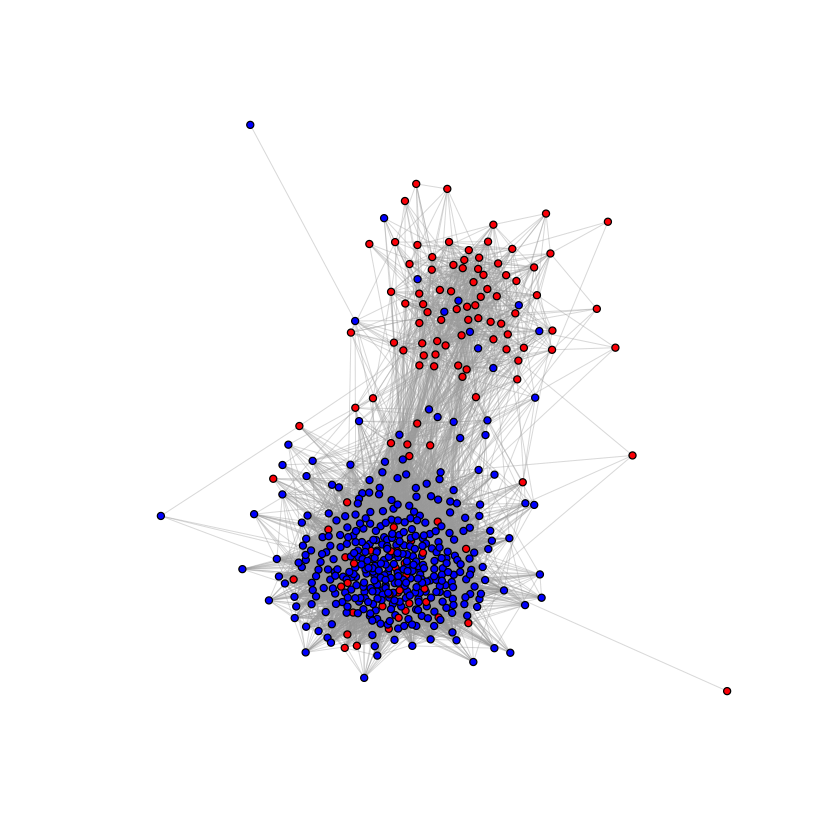

In [18]:
plot(
    g, 
    vertex.size=2.5, 
    vertex.label=NA, 
    edge.width=0.3, 
    layout=layout.fruchterman.reingold
)

Recall that when we generated this synthetic survey, we set the correlation between group type and response type to 0.9. We see this strong correlation bear out when we visualise with the force-directed layout. That is, clusters of nodes are mostly the same colour. 

It is obviously possible however that node data is entirely uncorrelated with the variables along which we observe polarisation. We recover this by setting correlation to 0.5. Note that correlation is slightly misleading as a variable name, since it is really the probability that group types 0 and 1 correspond to response type 0 and 1, respectively. As such, when this value is 0.5 group assignment is entirely random.

If we have additional node metadata, such as the interred community label that a community detection algorithm might produce, then we might use the Jaccard index to quantify the overlap betweeen these sets. 

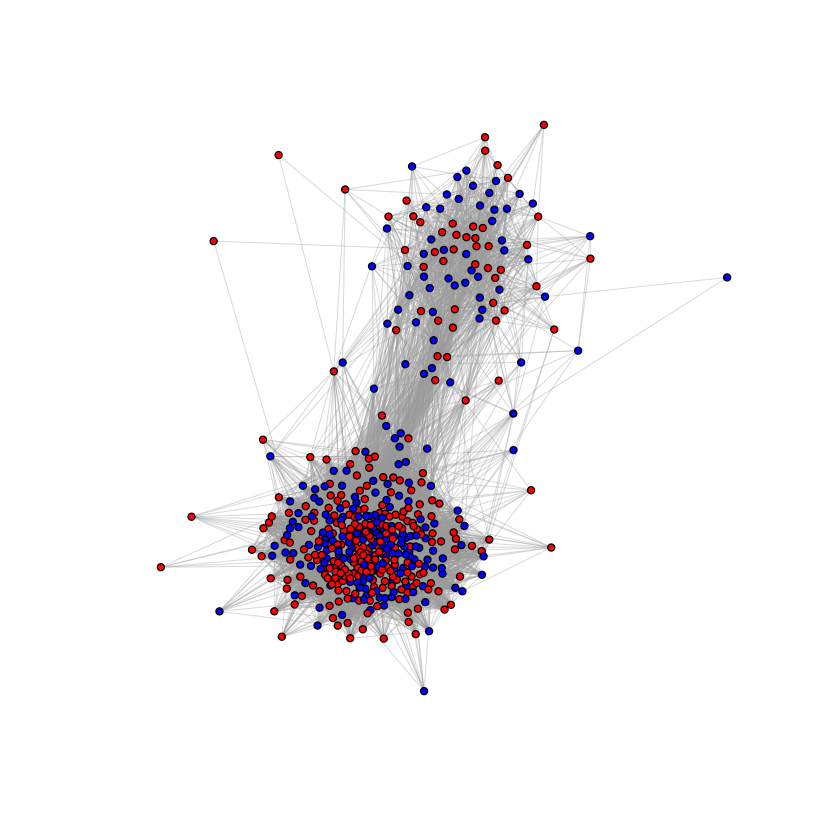

In [19]:
# correlation 0.5
S50 <- make_synthetic_data(
    nrow=500, 
    ncol=10, 
    polarisation=0.22, 
    correlation=0.5,
    minority=0.2
)

e50 <- make_projection(
    S50, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=1.0
)

nodedata <- data.frame(
    id=c(1:length(S50$group)), 
    group=S50$group
)

g50 <- graph_from_data_frame(
    e50, 
    vertices=nodedata, 
    directed=FALSE
)

V(g50)$color <- ifelse(
    V(g50)$group == '1', 
    "blue", 
    "red"
)

plot(
    g50, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold
)

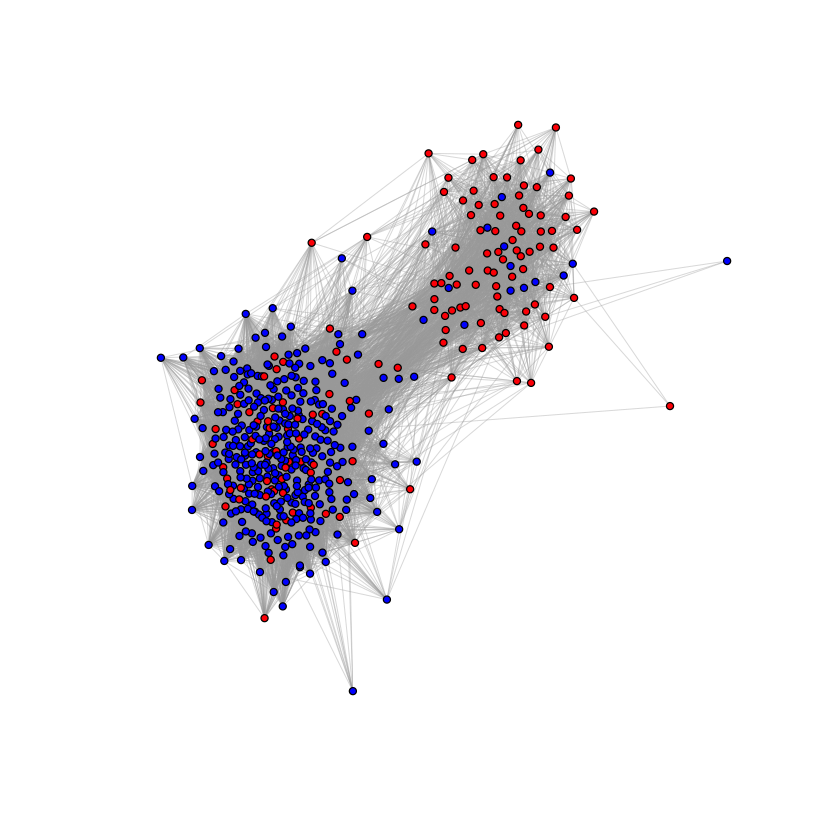

In [20]:
# correlation 0.85
S85 <- make_synthetic_data(
    nrow=500, 
    ncol=10, 
    polarisation=0.22, 
    correlation=0.85,
    minority=0.2
)

e85 <- make_projection(
    S85, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=1.0
)

nodedata <- data.frame(
    id=c(1:length(S85$group)), 
    group=S85$group
)

g85 <- graph_from_data_frame(
    e85, 
    vertices=nodedata, 
    directed=FALSE
)

V(g85)$color <- ifelse(
    V(g85)$group == '1', 
    "blue", 
    "red"
)

plot(
    g85, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold
)

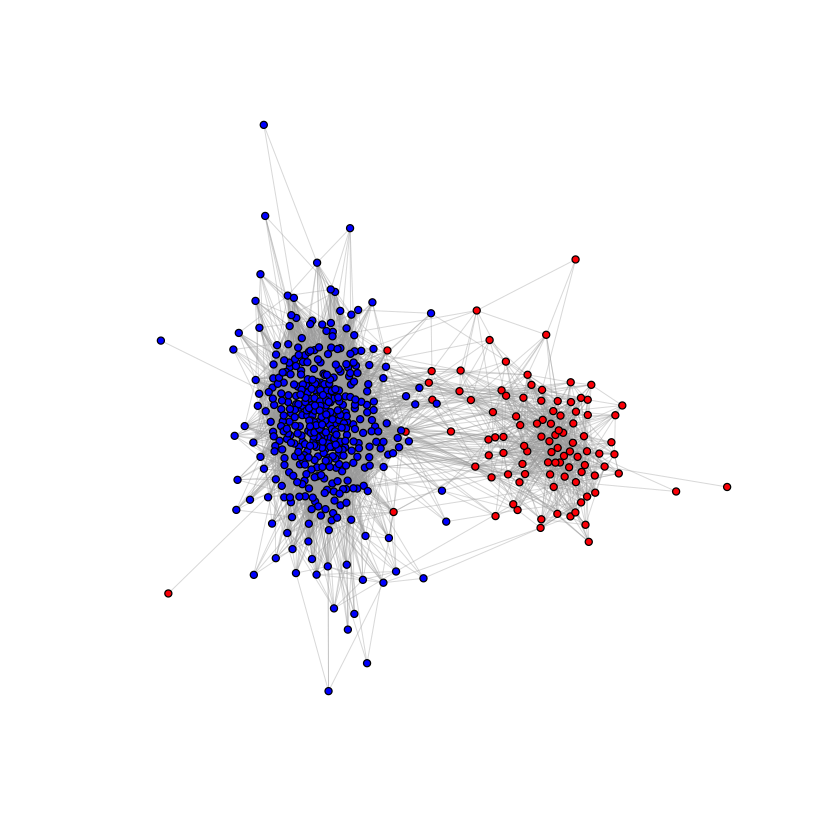

In [21]:
# correlation 1
S100 <- make_synthetic_data(
    nrow=500, 
    ncol=10, 
    polarisation=0.22, 
    correlation=1,
    minority=0.2
)

e100 <- make_projection(
    S100, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=1.0
)

nodedata <- data.frame(
    id=c(1:length(S100$group)), 
    group=S100$group
)

g100 <- graph_from_data_frame(
    e100, 
    vertices=nodedata, 
    directed=FALSE
)

V(g100)$color <- ifelse(
    V(g100)$group == '1', 
    "blue", 
    "red"
)

plot(
    g100, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold
)

Finally, note that there if there is no polarisation in the responses themselves, it doesn't matter what the group correlation variable is set to, there will be no discernible structure in the graph.

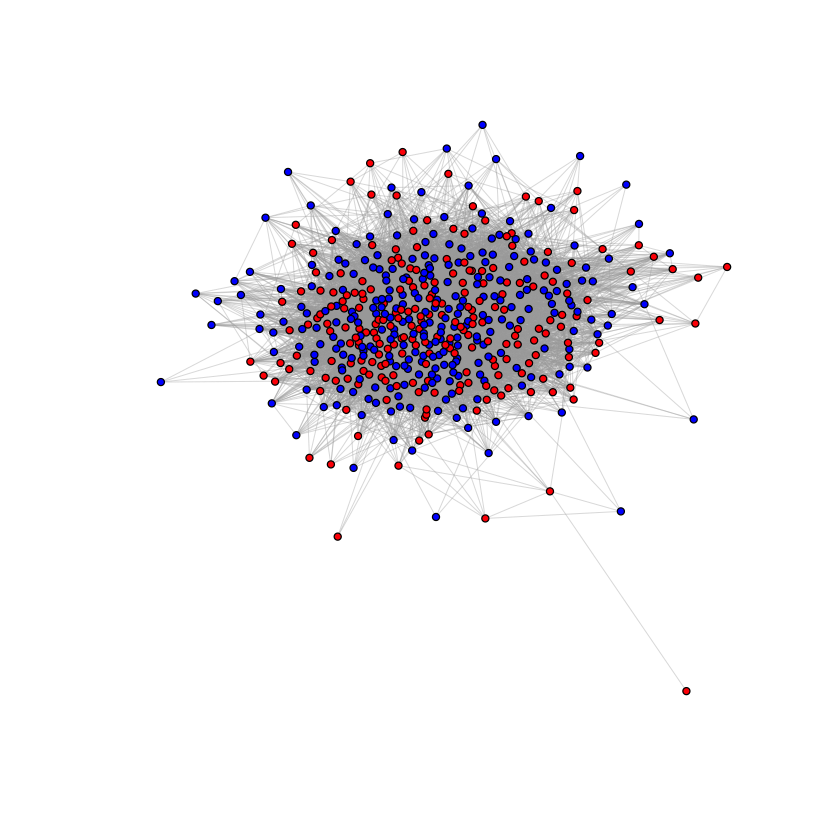

In [22]:
S <- make_synthetic_data(
    nrow=500, 
    ncol=10, 
    polarisation=0, 
    correlation=0.5,
    minority=0.2
)

e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=1.0
)

nodedata <- data.frame(
    id=c(1:length(S$group)), 
    group=S$group
)

g <- graph_from_data_frame(
    e, 
    vertices=nodedata, 
    directed=FALSE
)

V(g)$color <- ifelse(
    V(g)$group == '1', 
    "blue", 
    "red"
)

plot(
    g, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold
)

### Visualising subsets of nodes

It is straightforward to produce subgraphs of a given graph. To do this, we make use of the `which()` function of R. This returns the indices of an vector that have the boolean value true. For instance, the following code returns the vector indices containing the value 1.

In [23]:
var <- c(0, 1, 2, 5, 1)

# which(var == 1)

We apply this to a graph by specifying its colour, for instance the following returns the indices of all nodes whose colour is red.

In [24]:
# which(V(g85)$color == "red")

A node-induced subgraph is the graph formed by a subset of nodes in a given graph, as well as the maximal set of edges between nodes in that subset. This contrasts with an edge-induced subgraph, which specifies the subset of edges, rather than nodes, of the graph.

We use the `induced_subgraph()` function of _igraph_, along with the `which()` function in R, as follows.

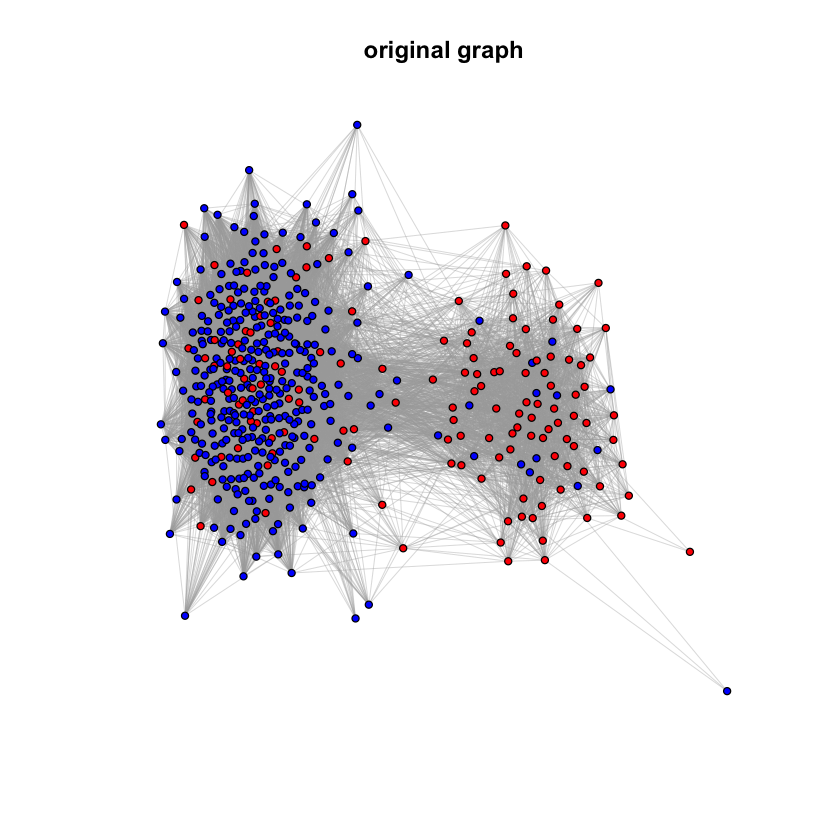

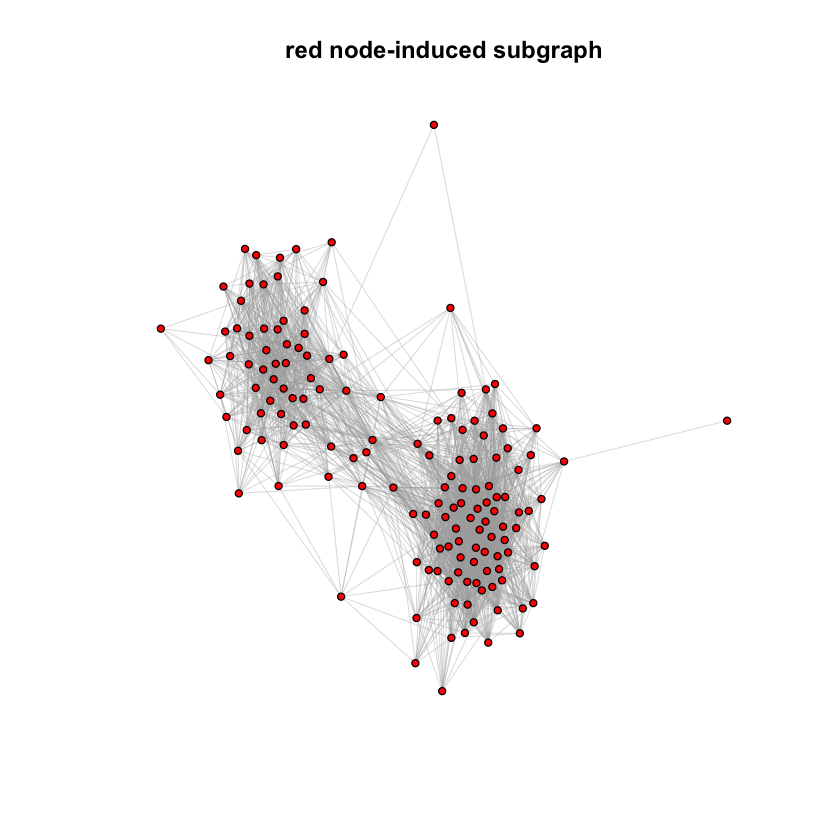

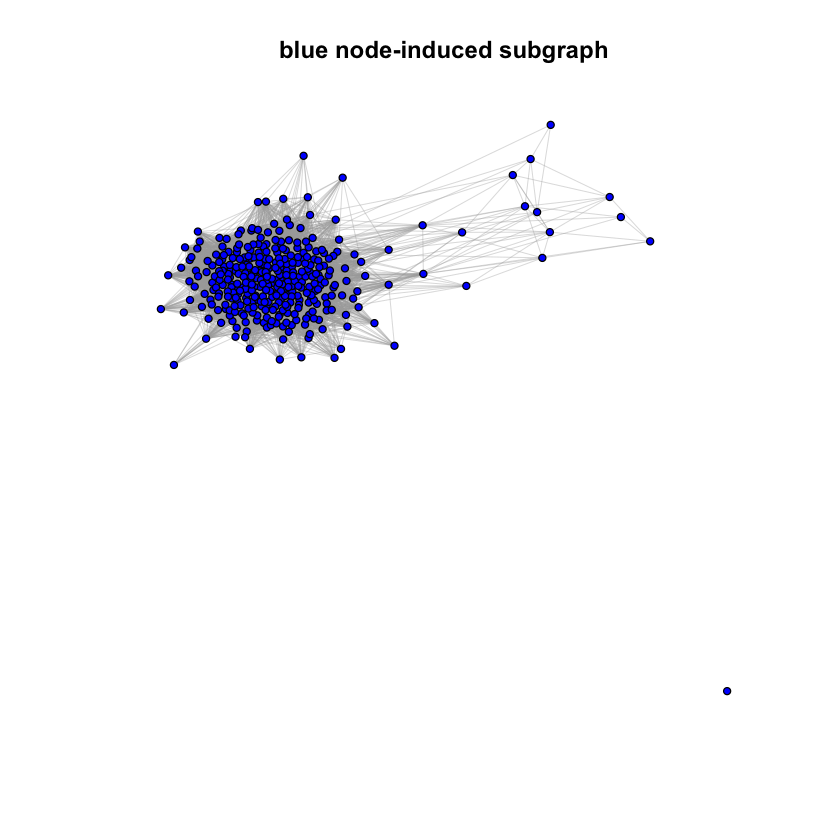

In [25]:
g85red <- induced_subgraph(g85, which(V(g85)$color == "red"))

g85blue <- induced_subgraph(g85, which(V(g85)$color == "blue"))

plot(
    g85, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold,
    main="original graph"
)

plot(
    g85red, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold,
    main="red node-induced subgraph"
)

plot(
    g85blue, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold,
    main="blue node-induced subgraph"
)

### Removing isolated nodes

We may also wish to visualise the graph without isolated nodes. Recall that these are nodes with no neighbours, meaning they have degree zero. Again we use the `which()` function to achieve this, as well as the `degree()` function in _igraph_, which takes a graph as an argument, and returns a vector of the degrees of each node.

We apply this to the following subgraph that contains isolated nodes.

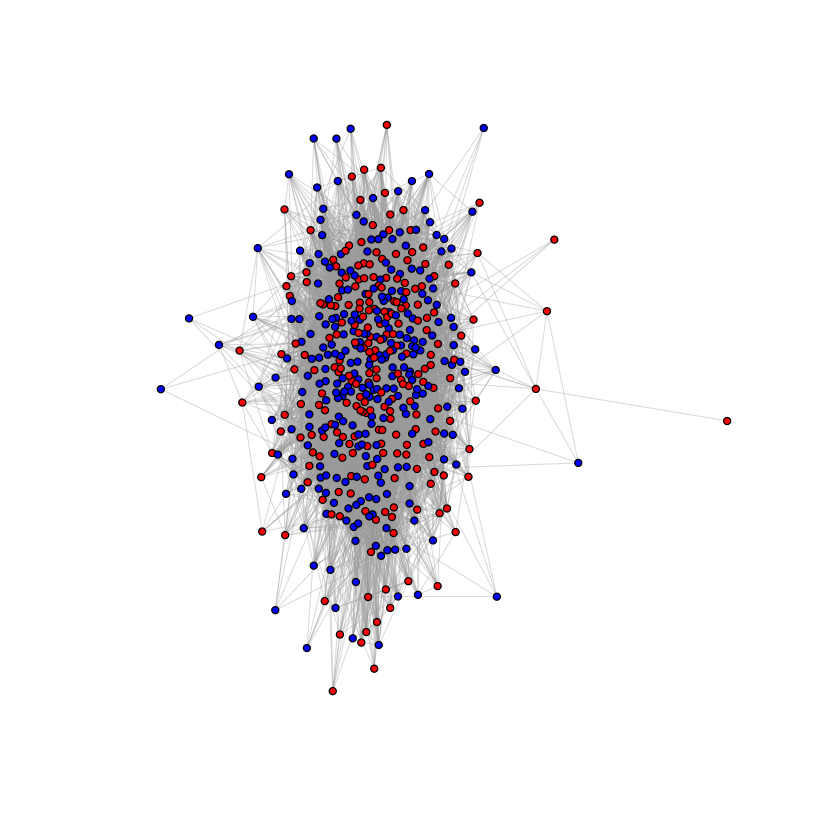

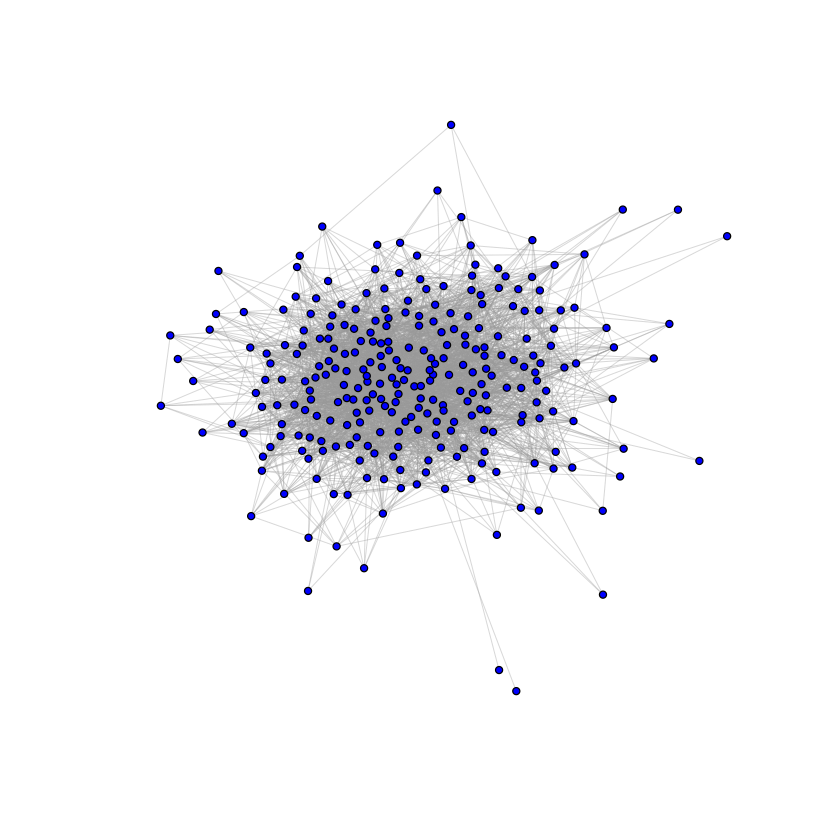

In [26]:
gblue <- induced_subgraph(g, which(V(g)$color == "blue"))

plot(
    g, 
    vertex.size=2.5, 
    vertex.label=NA, 
    edge.width=0.3, 
    layout=layout.fruchterman.reingold,
)

plot(
    gblue, 
    vertex.size=2.5, 
    vertex.label=NA, 
    edge.width=0.3, 
    layout=layout.fruchterman.reingold,
)

We now replot the blue subgraph containing only nodes that don't have degree 0. The indices of such nodes are given by the expression

In [27]:
# which(degree(gblue) != 0)

where `!=` is standard syntax meaning _not equal to_. Alternatively, the function `delete_vertices()` exists in _igraph_, which we might use by specifiying the nodes that have degree 0. We would do this using the expression

In [28]:
# which(degree(gblue) == 0)

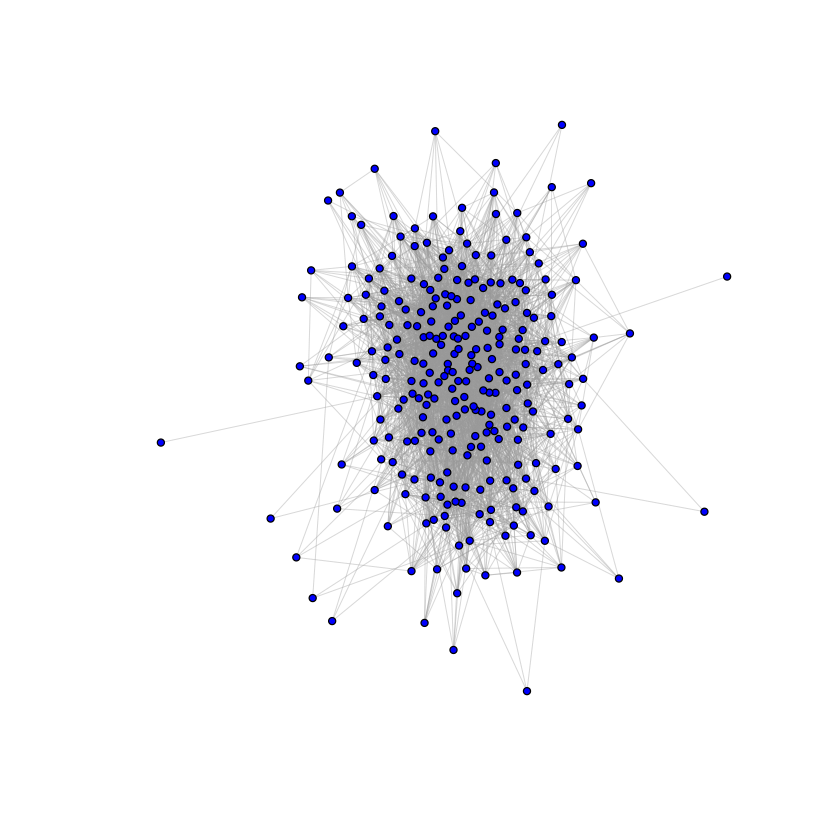

In [29]:
gbluec <- induced_subgraph(gblue, which(degree(gblue) != 0))

plot(
    gbluec, 
    vertex.size=2.5, 
    vertex.label=NA, edge.width=0.3, 
    layout=layout.fruchterman.reingold,
)

### Varying the similarity threshold

Since community detection methods usually ignore edge weights, we need to experiment with thresholding when applying community detection. Diconnected components and isolated nodes. The ideal threshold one that produces a fully-connected graph using the minimal number of edges.

NEED TO DEFINE VERTICES WITH "vertices=data.frame"

In [30]:
S <- make_synthetic_data(
    nrow=1000, 
    ncol=10, 
    polarisation=0.20,
    minority=0.3
)

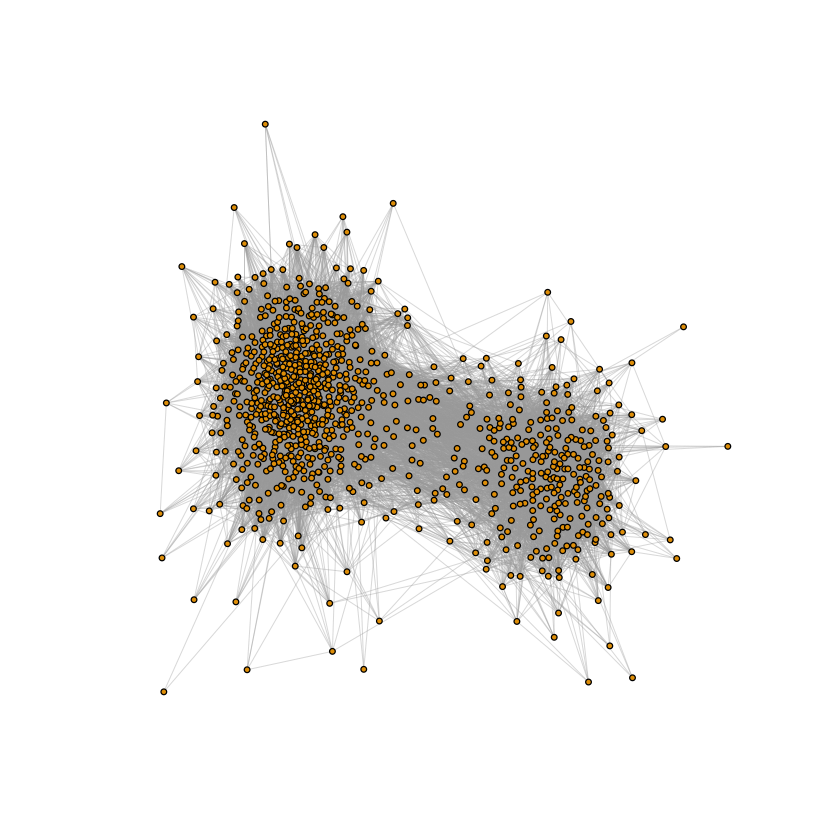

In [31]:
# largest connected component 1.0
e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=1
)

g <- graph_from_data_frame(
    e, 
    vertices=c(1:length(S$group)),
    directed=FALSE
)

plot(
    g, 
    vertex.size=2, 
    vertex.label=NA, 
    edge.width=0.3, 
    layout=layout.fruchterman.reingold
)

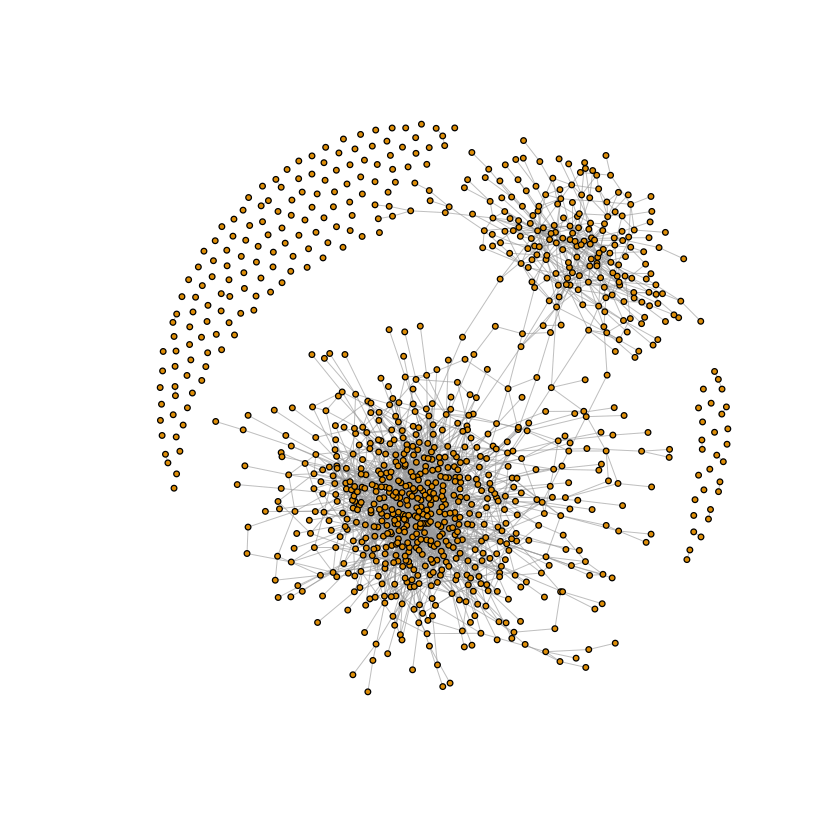

In [32]:
# largest connected component 0.8
e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=0.8
)

g <- graph_from_data_frame(
    e, 
    vertices=c(1:length(S$group)),
    directed=FALSE
)

plot(
    g, 
    vertex.size=2, 
    vertex.label=NA, 
    edge.width=0.5, 
    layout=layout.fruchterman.reingold
)

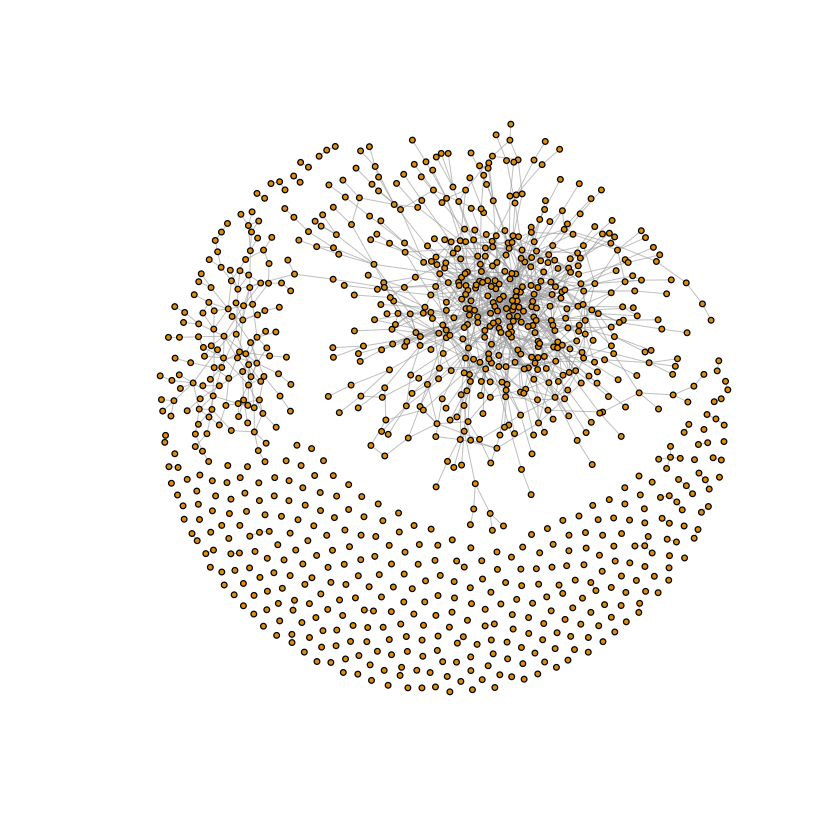

In [33]:
# largest connected component 0.6
e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=0.6
)

g <- graph_from_data_frame(
    e, 
    vertices=c(1:length(S$group)),
    directed=FALSE
)

plot(
    g, 
    vertex.size=2, 
    vertex.label=NA, 
    edge.width=0.5, 
    layout=layout.fruchterman.reingold
)

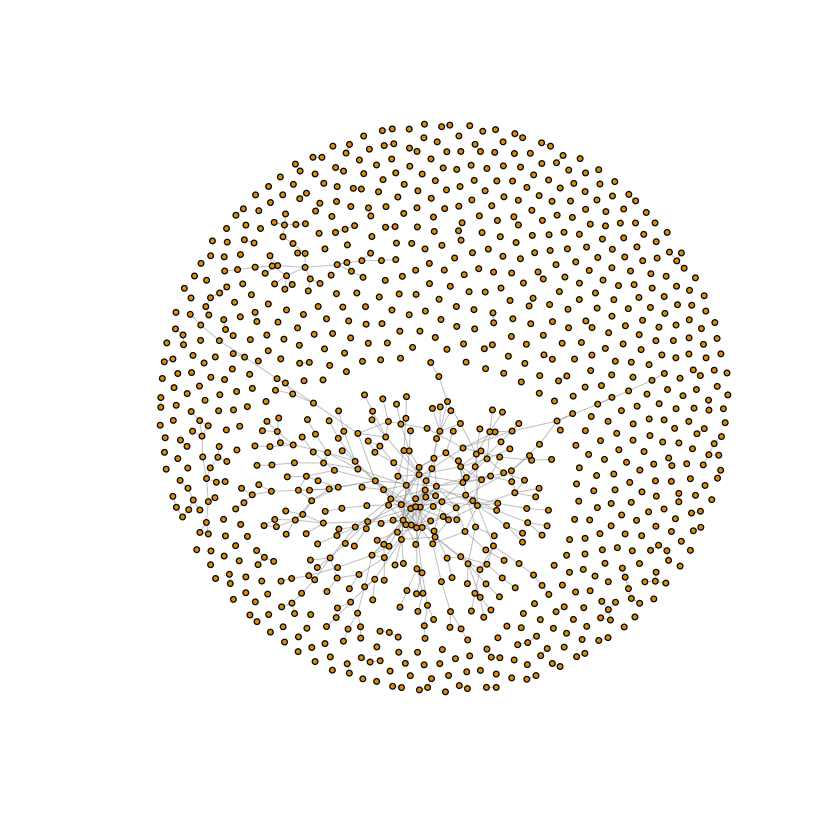

In [34]:
# largest connected component 0.4
e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=0.4
)

g <- graph_from_data_frame(
    e,
    vertices=c(1:length(S$group)),
    directed=FALSE
)

plot(
    g, 
    vertex.size=2, 
    vertex.label=NA, 
    edge.width=0.5, 
    layout=layout.fruchterman.reingold
)

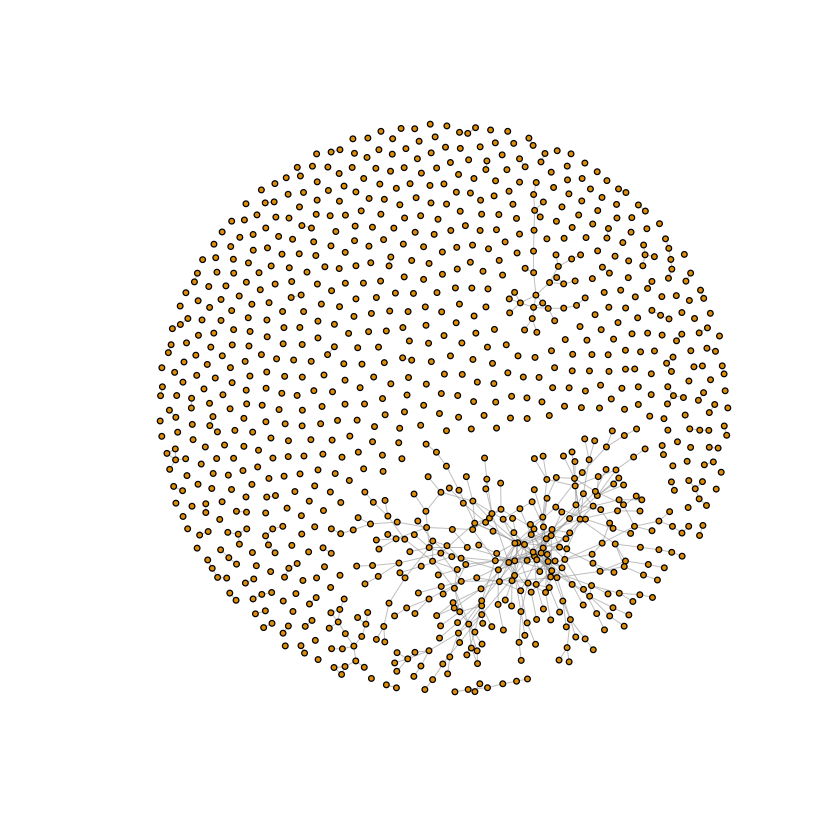

In [35]:
# largest connected component 0.2
e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=0.2
)

g <- graph_from_data_frame(
    e,
    vertices=c(1:length(S$group)),
    directed=FALSE
)

plot(
    g, 
    vertex.size=2, 
    vertex.label=NA, 
    edge.width=0.5, 
    layout=layout.fruchterman.reingold
)

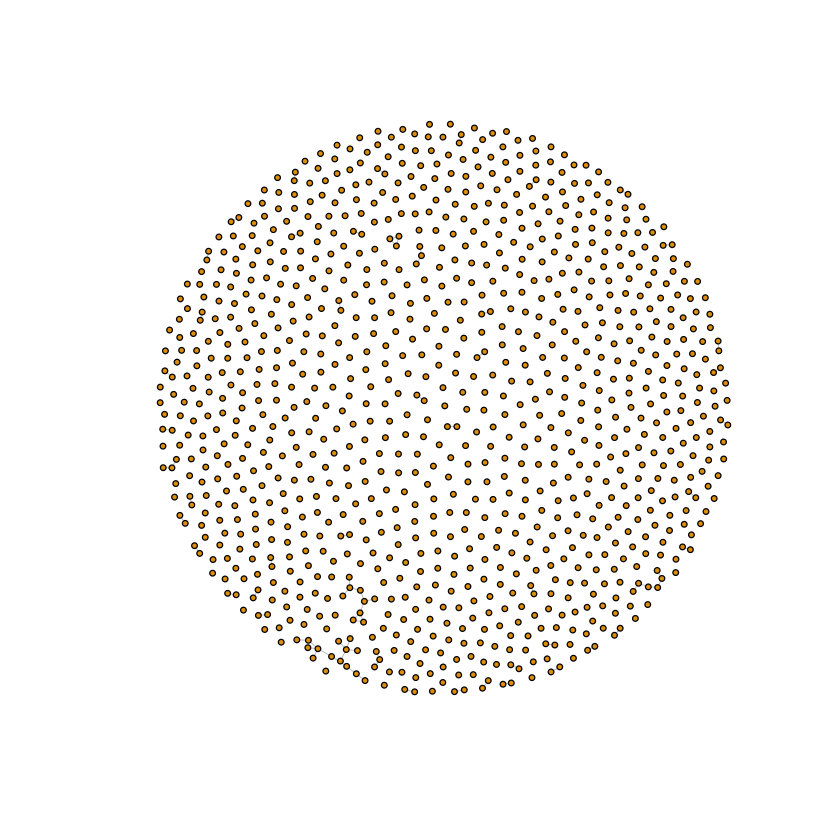

In [36]:
# largest connected component 0.00
e <- make_projection(
    S, 
    layer="agent", 
    threshold_method="target_lcc", 
    method_value=0.01
)

g <- graph_from_data_frame(
    e,
    vertices=c(1:length(S$group)),
    directed=FALSE
)

plot(
    g, 
    vertex.size=2, 
    vertex.label=NA,
    edge.width=0.5, 
    layout=layout.fruchterman.reingold
)

## Example with empirical survey data

Let us reload the Growing Up in Ireland dataset that we used in a previous notebook.

In [38]:
gui <- read.csv("https://raw.githubusercontent.com/surveygraph/surveygraph-tutorials/main/ICSIH/data/gui.csv")

gui <- gui[c(
    "criesnerves",              # when baby cries, how often does it get on your nerves?
    "talktobaby",               # do you talk to baby while you are busy doing other things?
    "wakeforfeed",              # do you ever wake baby for a feed during the night?
    "wherebabysleep",           # where does baby usually sleep?
    "babycryingproblem",        # do you feel that baby's crying is a problem for you?
    "sleepingproblemforyou",    # how much is baby's sleeping pattern a problem for you?
    "siblings",                 # does baby have siblings living in this household?
    "babyeverbreastfed"         # was baby ever breastfed?
)]

gui <- (na.omit(gui))

gui <- head(gui, 200)

We produce an edgelist,

In [39]:
e <- make_projection(gui, layer="agent", threshold_method="lcc")

and create an _igraph_ object from that edgelist.

In [40]:
g <- graph_from_data_frame(e, directed=FALSE)

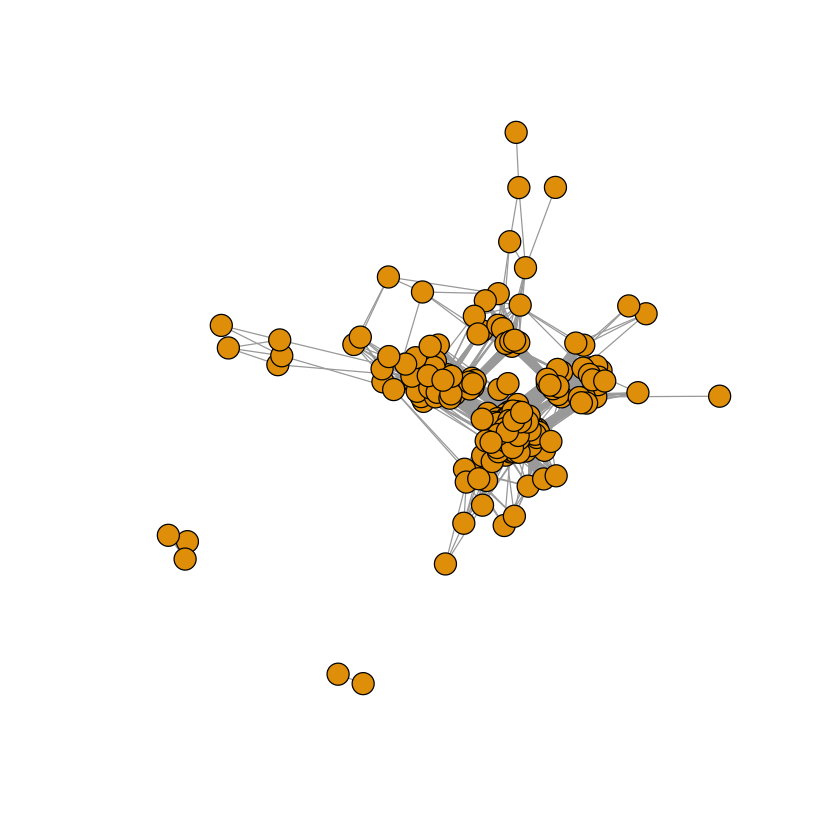

In [41]:
plot(
    g, 
    vertex.size=8, 
    vertex.label=NA, 
    layout=layout.fruchterman.reingold
)

## Walktrap

In [42]:
walktrap <- cluster_walktrap(g, steps=4)

V(g)$color <- walktrap$membership

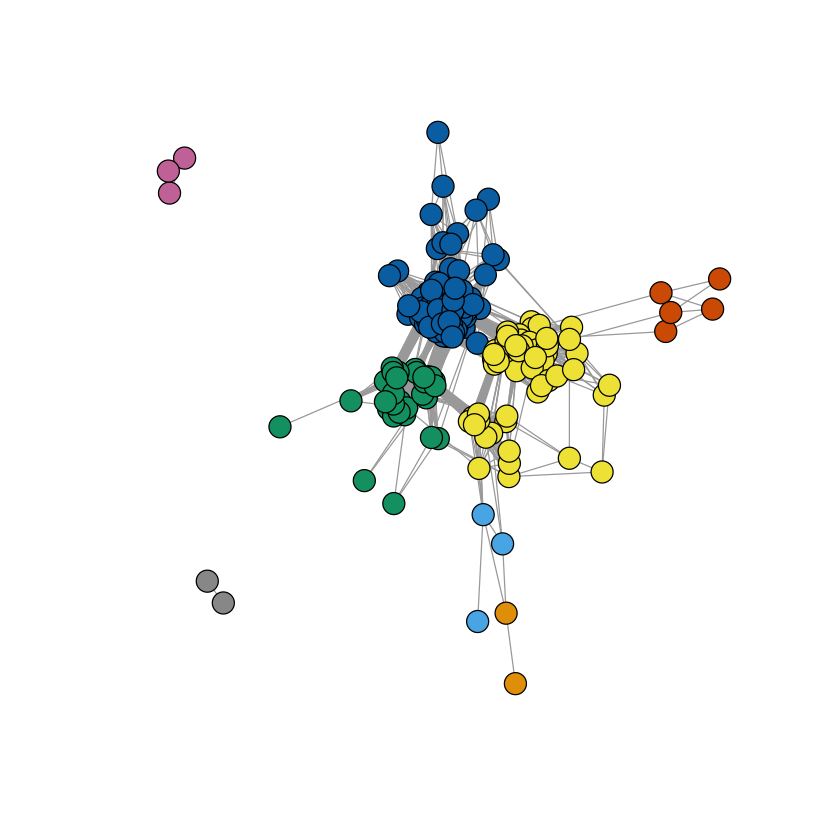

In [43]:
plot(
    g, 
    vertex.size=8, 
    vertex.label=NA, 
    layout=layout.fruchterman.reingold
)

### Newman-Girvan

In [44]:
newmangirvan <- cluster_edge_betweenness(g)

V(g)$color <- newmangirvan$membership

Warning message in cluster_edge_betweenness(g):
“At vendor/cigraph/src/community/edge_betweenness.c:498 : Membership vector will be selected based on the highest modularity score.”


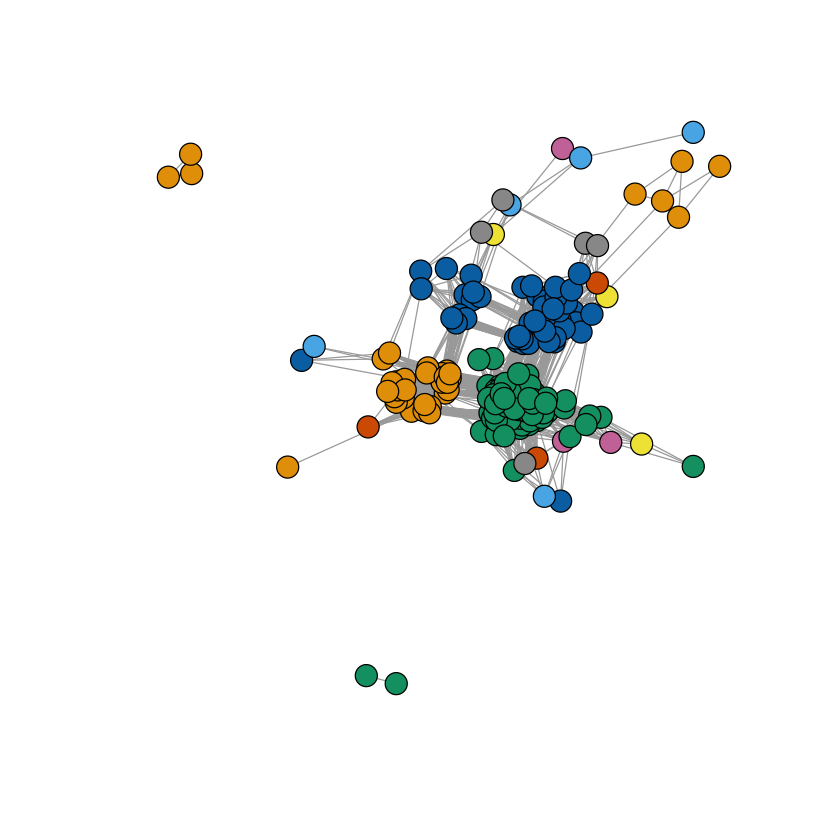

In [45]:
plot(
    g, 
    vertex.size=8, 
    vertex.label=NA, 
    layout=layout.fruchterman.reingold
)

### Louvain

In [46]:
louvain <- cluster_louvain(g)

V(g)$color <- louvain$membership

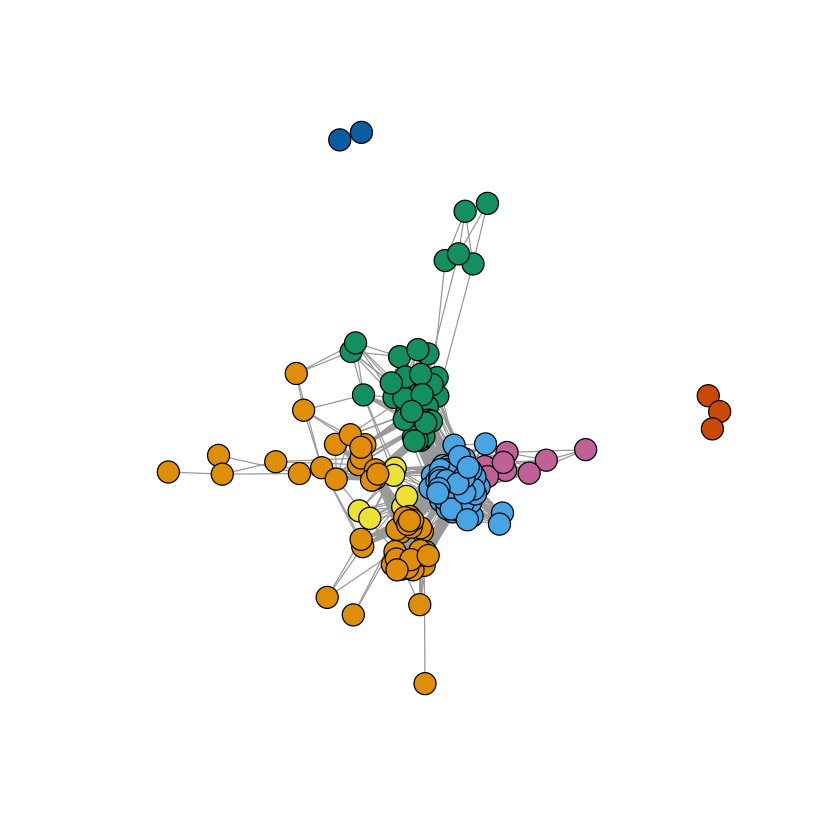

In [47]:
plot(
    g, 
    vertex.size=8, 
    vertex.label=NA, 
    layout=layout.fruchterman.reingold
)

# Appendix A. Jupyter notebook configuration

## Configuring HTML and CSS

In [370]:
library('IRdisplay')

The above package allows us to define custom CSS styles. 

In [375]:
# define custom CSS styles
customcss <- "
<style>
  .sidenote-cell {
    overflow-x: hidden;
    background-color: lightblue;
    padding: 10px;
    width: calc(100% + 40px);
    margin-left: -10px;
    box-sizing: border-box;
  }
</style>
"

# display the custom CSS styles
IRdisplay::display_html(customcss)

## Configuring plot dimensions

In [429]:
options(repr.plot.width = 8, repr.plot.height = 8)